In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore_async
from dateutil.relativedelta import relativedelta
import datetime
from datetime import date
import operator
from collections import Counter

In [2]:
cred = credentials.Certificate("book-friends-1e196-865279fa4b09.json")
firebase_admin.initialize_app(cred)
db = firestore_async.client()

In [3]:
def getAge(birthDate):
    try:
        today = date.today()
        dateX = birthDate.split(' ')[0].split('-')
        birth = date(int(dateX[0]), int(dateX[1]), int(dateX[2]))
        difference = relativedelta(today, birth)
    except:
        return -1
    return difference.years

def Average(lst):
    return sum(lst) / len(lst)

questions = dict()

Q1: (Type 5: 2-3) What is the average number of words when a post is created?

In [4]:
posts_ref = db.collection("posts")
docs = posts_ref.stream()

words = list()
async for doc in docs:
    actual = doc.to_dict()
    words.append(len(actual['content']))
rtaQ1 = round(Average(words), 2)
questions['Q1'] = ('(Type 5: 2-3) What is the average number of words when a post is created?', rtaQ1)

Q2: (Type 3) What is the percentage of users that are minors (under 18 age)?

In [5]:
users_ref = db.collection("users")
docs = users_ref.stream()

under18 = 0
total = 0
async for doc in docs:
    actual = doc.to_dict()
    st = str(actual['birthDate'])
    age = getAge(st)
    if age != -1 and age < 18:
        under18 = under18 + 1
    total = total + 1
rtaQ2 = round(under18*100/total, 2)
questions['Q2'] = ('(Type 3) What is the percentage of users that are minors (under 18 age)?', f"{rtaQ2}%")

In [6]:
for key, value in questions.items():
    print(key, '-',value[0])
    print('ans', '-',value[1])
    print()

Q1 - (Type 5: 2-3) What is the average number of words when a post is created?
ans - 35.64

Q2 - (Type 3) What is the percentage of users that are minors (under 18 age)?
ans - 16.67%



Q3: (Type 4) What is the average amount of users per reading plan?

Q3 - (Type 4) What is the amount of users per reading plan?
ans - On average: 1.56


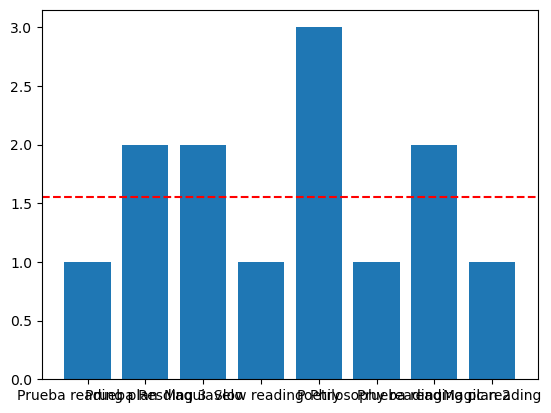

In [7]:
readingPlans_ref = db.collection("readingPlans")
docs = readingPlans_ref.stream()

df = pd.DataFrame()
readingPlans = list()
count = list()
async for doc in docs:
    actual = doc.to_dict()
    readingPlans.append(actual['title'])
    count.append(len(actual['usersIds']))
df['Reading Plans'] = readingPlans
df['# users'] = count
average = round(Average(df['# users']), 2)

print('Q3 - (Type 4) What is the amount of users per reading plan?')
print('ans -', 'On average:', average)
plt.bar(df['Reading Plans'], df['# users'])
plt.axhline(y=np.nanmean(df['# users']), color='red', linestyle='--')
plt.show()

Q4: (Type 4) What are the genres of books that have the highest number of notes created and different users creating the notes?

Q4 - (Type 4) What are the genres of books that have the highest number of notes created and different users creating the notes?


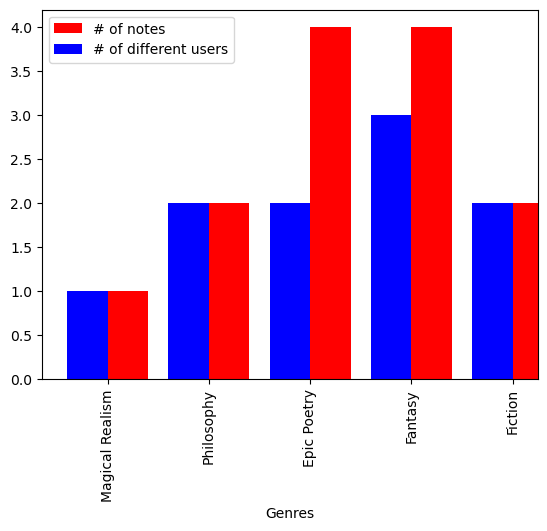

In [8]:
notes_ref = db.collection("notes")
docs_notes = notes_ref.stream()

books_ref = db.collection("books")
docs_books = books_ref.stream()

df = pd.DataFrame()
booksIds = list()
genresIds = list()
genres = dict()
counts = list()

def getBookGenre(bookid):
    for idBook, genre in genresIds:       # buscamose el genero del book
        if idBook == bookid:
            return genre

async for note in docs_notes:
    actualNote = note.to_dict()
    booksIds.append((actualNote['bookId'], actualNote['userId']))
    
async for book in docs_books:
    actualBook = book.to_dict()
    genresIds.append((book.id, actualBook['genre']))

for bookid, userid in booksIds: # por cada note book,user
    genre = getBookGenre(bookid)
    if genre in genres.keys():
        users = genres[genre][1]
        users.append(userid)
        number = genres[genre][0] + 1
        genres[genre] = (number, users)
    else:
        genres[genre] = (1, [userid])

genresList = list()
numberNotesList = list()
numberDifUserList = list()
for genre in genres:
    number = genres[genre][0]
    diferentUsers = len(Counter(genres[genre][1]).keys()) 
    genres[genre] = (number, diferentUsers)
    genresList.append(genre)
    numberNotesList.append(number)
    numberDifUserList.append(diferentUsers)

df = pd.DataFrame(list(zip(genresList, numberNotesList,numberDifUserList)),
               columns =['Genres', '# of notes', '# of different users'])

fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.4
df.set_index('Genres').plot(y = '# of notes', kind='bar', color='red', ax=ax, width=width, position=0, legend = True)
df.set_index('Genres').plot(y = '# of different users', kind='bar', color='blue', ax=ax, width=width, position=1, legend = True)
plt.legend = True
print('Q4 - (Type 4) What are the genres of books that have the highest number of notes created and different users creating the notes?')
plt.show()

Q5: What are the 5 most used words in discussion topics?

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

discussions_ref = db.collection("discussions")
docs = discussions_ref.stream()

df = pd.DataFrame()
topics = list()

async for doc in docs:
    actual = doc.to_dict()
    topics.append(actual['topic'])

wordfreq = {}
unwanted_chars = ".,-_?!$%&*@#[]{}'\""
unwanted_strings = stopwords.words('english')
aux = ['What','what','how','How','Who','who']
unwanted_strings = unwanted_strings + aux


for topic in topics:
    words = topic.split()
    for raw_word in words:
        if raw_word not in unwanted_strings:
            word = raw_word.strip(unwanted_chars)
            if word not in wordfreq:
                wordfreq[word] = 0 
            wordfreq[word] += 1

wordfreq = sorted(wordfreq.items(), key=lambda x: x[1], reverse=True)

print('Q5 - (Type 2) What are the 10 most used words in discussion topics?')
print('Top 10 frequent words:')
for i in range(0,5):
    print('\t*', wordfreq[i][0], '->', wordfreq[i][1])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vhane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Q5 - (Type 2) What are the 10 most used words in discussion topics?
Top 10 frequent words:
	* favorite -> 3
	* character -> 3
	* feel -> 2
	* main -> 2
	* reading -> 2
